In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
data = pd.read_csv(r"/content/drive/MyDrive/BERT Variations/all_in_one.csv", encoding='utf-8')
data = data.fillna(method='ffill')
data.head(50)

,Sentence ID,Word,Tag
0,1,The,O
1,1,admin@338,B-HackOrg
2,1,has,O
3,1,largely,O
4,1,targeted,O
5,1,organizations,O
6,1,involved,O
7,1,in,O
8,1,financial,B-Idus
9,1,",",O


In [6]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)

In [8]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['The',
 'admin@338',
 'has',
 'largely',
 'targeted',
 'organizations',
 'involved',
 'in',
 'financial',
 ',',
 'economic',
 'and',
 'trade',
 'policy',
 ',',
 'typically',
 'using',
 'publicly',
 'available',
 'RATs',
 'such',
 'as',
 'Poison',
 'Ivy',
 ',',
 'as',
 'well',
 'some',
 'non-public',
 'backdoors',
 '.']

In [9]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'B-HackOrg', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Idus', 'O', 'B-Idus', 'O', 'B-Idus', 'I-Idus', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'I-Tool', 'O', 'O', 'B-Tool', 'I-Tool', 'O', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'O']


In [10]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

print(tag_values)

print(tag2idx)

['I-Area', 'B-Area', 'I-Org', 'I-Purp', 'B-Idus', 'B-Way', 'I-Tool', 'B-Time', 'B-Purp', 'O', 'I-SecTeam', 'I-SamFile', 'I-Way', 'B-OffAct', 'B-SamFile', 'I-HackOrg', 'B-Features', 'I-Time', 'I-Features', 'B-Org', 'B-Tool', 'I-OffAct', 'B-Exp', 'I-Exp', 'I-Idus', 'B-HackOrg', 'B-SecTeam', 'PAD']
{'I-Area': 0, 'B-Area': 1, 'I-Org': 2, 'I-Purp': 3, 'B-Idus': 4, 'B-Way': 5, 'I-Tool': 6, 'B-Time': 7, 'B-Purp': 8, 'O': 9, 'I-SecTeam': 10, 'I-SamFile': 11, 'I-Way': 12, 'B-OffAct': 13, 'B-SamFile': 14, 'I-HackOrg': 15, 'B-Features': 16, 'I-Time': 17, 'I-Features': 18, 'B-Org': 19, 'B-Tool': 20, 'I-OffAct': 21, 'B-Exp': 22, 'I-Exp': 23, 'I-Idus': 24, 'B-HackOrg': 25, 'B-SecTeam': 26, 'PAD': 27}


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'2.2.1+cu121'

In [12]:
MAX_LEN = 75
bs = 32
#batch size = bs
# sentence length fixed to 75 i.e. 75 tokens

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('princeton-nlp/sup-simcse-roberta-large')

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [18]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [19]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [20]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [21]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [22]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [23]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [24]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [25]:
# convert to torch tenors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [26]:
#training time shuffling of the data and testing time we pass them sequentially
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [27]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.40.2'

In [29]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "princeton-nlp/sup-simcse-roberta-large",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at princeton-nlp/sup-simcse-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
    

In [31]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-4,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
#schduler to reduce learning rate linearly throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [33]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=060aa5301c2225bb03f8f9bbdc5ad6bd58faa330b229a936f90f7296905e51ea
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [34]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):

    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)


    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.5935789525508881


Epoch:  10%|█         | 1/10 [01:54<17:09, 114.37s/it]

Validation loss: 0.33889386519080117
Validation Accuracy: 0.8926289682539683
Average train loss: 0.23521837619217958


Epoch:  20%|██        | 2/10 [03:48<15:12, 114.12s/it]

Validation loss: 0.2337947558789026
Validation Accuracy: 0.9301825396825394
Average train loss: 0.1519718465028387


Epoch:  30%|███       | 3/10 [05:42<13:18, 114.08s/it]

Validation loss: 0.17426162355002903
Validation Accuracy: 0.9494900793650791
Average train loss: 0.10477886028362043


Epoch:  40%|████      | 4/10 [07:36<11:24, 114.09s/it]

Validation loss: 0.158963014682134
Validation Accuracy: 0.955595238095238
Average train loss: 0.07264790907502175


Epoch:  50%|█████     | 5/10 [09:30<09:30, 114.11s/it]

Validation loss: 0.15826154730859257
Validation Accuracy: 0.9598373015873016
Average train loss: 0.052735540575601834


Epoch:  60%|██████    | 6/10 [11:24<07:36, 114.13s/it]

Validation loss: 0.15680600702762604
Validation Accuracy: 0.9617261904761902
Average train loss: 0.03984020510970643


Epoch:  70%|███████   | 7/10 [13:18<05:42, 114.14s/it]

Validation loss: 0.16601862456826938
Validation Accuracy: 0.9640873015873014
Average train loss: 0.027413737023192823


Epoch:  80%|████████  | 8/10 [15:13<03:48, 114.13s/it]

Validation loss: 0.16750622256880715
Validation Accuracy: 0.9662857142857142
Average train loss: 0.018491903525974716


Epoch:  90%|█████████ | 9/10 [17:07<01:54, 114.13s/it]

Validation loss: 0.17885383094350496
Validation Accuracy: 0.9669662698412697
Average train loss: 0.013017973120352536


Epoch: 100%|██████████| 10/10 [19:01<00:00, 114.13s/it]

Validation loss: 0.1812695012915702
Validation Accuracy: 0.9679980158730158


In [36]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

      B-Area       0.88      0.92      0.90       835
       B-Exp       0.99      0.99      0.99      1190
  B-Features       0.89      0.98      0.93       387
   B-HackOrg       0.89      0.91      0.90      2339
      B-Idus       0.89      0.88      0.88       592
    B-OffAct       0.79      0.82      0.81       598
       B-Org       0.79      0.78      0.78       495
      B-Purp       0.85      0.82      0.83       354
   B-SamFile       0.93      0.93      0.93       918
   B-SecTeam       0.95      0.92      0.94       618
      B-Time       0.88      0.90      0.89       364
      B-Tool       0.82      0.85      0.84      1636
       B-Way       0.84      0.80      0.82       503
      I-Area       0.85      0.85      0.85       284
       I-Exp       1.00      0.91      0.95       239
  I-Features       0.92      0.99      0.95       511
   I-HackOrg       0.81      0.86      0.83       478
      I-Idus       0.84    

In [37]:
p = []
t = []
for i in pred_tags:
  if i == 'O':
    p.append(i)
  else:
    p.append(i[2:])

for i in valid_tags:
  if i == 'O':
    t.append(i)
  else:
    t.append(i[2:])

In [38]:
from sklearn.metrics import classification_report
print(classification_report(t, p))

              precision    recall  f1-score   support

        Area       0.89      0.92      0.91      1119
         Exp       0.99      0.97      0.98      1429
    Features       0.91      0.99      0.95       898
     HackOrg       0.88      0.90      0.89      2817
        Idus       0.88      0.85      0.86       805
           O       0.97      0.96      0.97     36207
      OffAct       0.82      0.83      0.83       908
         Org       0.82      0.83      0.82      1004
        Purp       0.88      0.83      0.85       861
     SamFile       0.93      0.94      0.94      1118
     SecTeam       0.91      0.93      0.92       790
        Time       0.92      0.95      0.93       613
        Tool       0.82      0.86      0.84      2229
         Way       0.80      0.81      0.80       866

    accuracy                           0.94     51664
   macro avg       0.89      0.90      0.89     51664
weighted avg       0.94      0.94      0.94     51664



In [39]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['macro avg']['f1-score']

recall_weighted = report['macro avg']['recall']
precision_weighted = report['macro avg']['precision']

# Print the results

print ('Macro F1 Score: ', f1_weighted)
print ('Macro Recall: ', recall_weighted)
print ('Macro Precision: ', precision_weighted)

Macro F1 Score:  0.8928005563287719
Macro Recall:  0.8994490644336394
Macro Precision:  0.8867237223377231


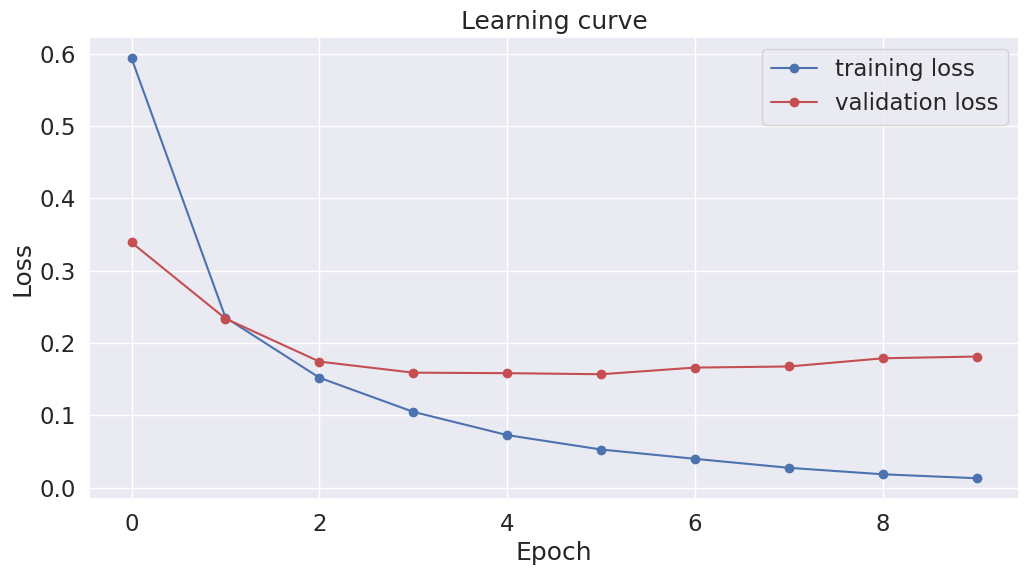

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()